In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

In [55]:
val_dataset[0] # 0.pkl

{'city': 'PIT',
 'lane': array([[3278.8716, 1968.7596,    0.    ],
        [3282.6606, 1972.2533,    0.    ],
        [3286.4429, 1975.7545,    0.    ],
        [3290.2249, 1979.2559,    0.    ],
        [3294.007 , 1982.7572,    0.    ],
        [3297.789 , 1986.2584,    0.    ],
        [3301.5713, 1989.7598,    0.    ],
        [3305.3533, 1993.2611,    0.    ],
        [3309.1355, 1996.7623,    0.    ],
        [3269.4802, 1967.0625,    0.    ],
        [3267.2764, 1965.0217,    0.    ],
        [3265.0664, 1962.9877,    0.    ],
        [3262.8562, 1960.9536,    0.    ],
        [3260.646 , 1958.9197,    0.    ],
        [3258.436 , 1956.8856,    0.    ],
        [3256.2258, 1954.8517,    0.    ],
        [3254.0132, 1952.8207,    0.    ],
        [3251.7898, 1950.8013,    0.    ],
        [3235.7622, 1935.9915,    0.    ],
        [3231.5237, 1932.1249,    0.    ],
        [3227.2852, 1928.2582,    0.    ],
        [3223.0923, 1924.343 ,    0.    ],
        [3218.9045, 1920.4214,

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(19, 30)
        
    def forward(self, x):
        x = F.relu(self.lin(x))
        return x
    
net = CNN()

In [10]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Create a loader to enable batch processing

In [6]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = [[s.ravel(order='F').reshape(4,19) for s in b] for b in inp]
    out = [[s.ravel(order='F').reshape(4,30) for s in b] for b in out]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #input has shape BxCxHxW and labels has shape B, print(inputs.shape) is a very useful function

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) #net.forward(inputs)
        loss = criterion(outputs, labels)  # loss = torch.mean((ouputs - labels)**2)+74
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

0
[1,  2000] loss: 212606.817
[1,  4000] loss: 216488.146
[1,  6000] loss: 215056.209
[1,  8000] loss: 216583.856
[1, 10000] loss: 214649.354
10000
[1, 12000] loss: 213582.587
[1, 14000] loss: 214699.931
[1, 16000] loss: 216223.919
[1, 18000] loss: 214783.058
[1, 20000] loss: 216560.931
20000
[1, 22000] loss: 215271.500
[1, 24000] loss: 215337.237
[1, 26000] loss: 213957.719
[1, 28000] loss: 214445.960
[1, 30000] loss: 211441.543
30000
[1, 32000] loss: 217160.253
[1, 34000] loss: 213499.285
[1, 36000] loss: 214945.217
[1, 38000] loss: 217531.165
[1, 40000] loss: 212223.898
40000
[1, 42000] loss: 214987.456
[1, 44000] loss: 217344.148
[1, 46000] loss: 215780.605
[1, 48000] loss: 213183.158
[1, 50000] loss: 217771.281
50000
0
[2,  2000] loss: 212606.817
[2,  4000] loss: 216488.146
[2,  6000] loss: 215056.209
[2,  8000] loss: 216583.856
[2, 10000] loss: 214649.354
10000
[2, 12000] loss: 213582.587
[2, 14000] loss: 214699.931
[2, 16000] loss: 216223.919
[2, 18000] loss: 214783.058
[2, 2000

In [20]:
test_dataset  = ArgoverseDataset(data_path="./new_val_in/new_val_in/")
def my_test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = [[s.ravel(order='F').reshape(4,19) for s in b] for b in inp]
    inp = torch.FloatTensor(inp)
    return inp
test_loader = DataLoader(test_dataset, batch_size=batch_sz,shuffle=False, collate_fn=my_test_collate,num_workers=0)

In [61]:
pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # calculate outputs by running images through the network
        outputs = net(data)
        for b in range(len(outputs)):
            da = test_dataset[i*4+b]
            for i_d in range(len(da['track_id'])):
                if da['track_id'][i_d][0] == da['agent_id']:
                    break
            pred.append(outputs[b][i_d][:2])

In [75]:
import csv
with open('baseline.csv', mode='w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    title = ['0'] * 61
    title[0] = 'ID'
    for i in range(60):
        title[i+1] = 'v' + str(i+1)
    writer.writerow(title)
    
    for i in range(3200):
        row = [0] * 61
        row[0] = test_dataset[i]['scene_idx']
        x, y = pred[i]
        for j in range(30):
            row[j*2+1] = x[j].item()
            row[j*2+2] = y[j].item()
        writer.writerow(row)

### Visualize the batch of sequences

<ipython-input-7-e34a6e23e746>:7: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-7-e34a6e23e746>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)


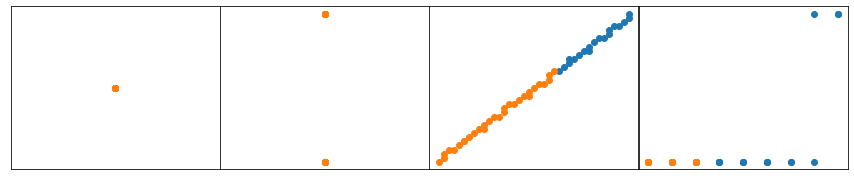

In [8]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break